In [20]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf

tf.keras.backend.clear_session()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Replace with your data directory path
import os
data_dir = './drive/MyDrive/final_project/Saved/'
list_A = os.listdir(data_dir)


In [22]:
!pip install vit-keras
!pip install tensorflow-addons

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from vit_keras import vit
from tensorflow.keras import layers, Model

# Step 1: Data Preparation

def load_data(data_dir):
    images = []
    labels = []

    for actor_folder in os.listdir(data_dir):
        actor_path = os.path.join(data_dir, actor_folder)
        if os.path.isdir(actor_path):
            for modality_folder in os.listdir(actor_path):
                modality_path = os.path.join(actor_path, modality_folder)
                if os.path.isdir(modality_path):
                    amplitude_img_path = os.path.join(modality_path, 'mono_data-channel-frequency.png')
                    if os.path.exists(amplitude_img_path):
                        image = load_img(amplitude_img_path, target_size=(224, 224))
                        image = img_to_array(image)
                        images.append(image)

                        # Extract emotion label from folder name
                        emotion_label = int(modality_folder.split('-')[2]) - 1  # Subtract 1 to make labels 0-based
                        labels.append(emotion_label)

    images = np.array(images) / 255.0  # Normalize images
    labels = tf.keras.utils.to_categorical(labels, num_classes=8)  # One-hot encode emotion labels

    return images, labels

'''
def load_data(data_dir):
  images = []
  labels = []

  for actor_folder in os.listdir(data_dir):
      actor_path = os.path.join(data_dir, actor_folder)
      if os.path.isdir(actor_path):
          for modality_folder in os.listdir(actor_path):
              modality_path = os.path.join(actor_path, modality_folder)
              if os.path.isdir(modality_path):
                  amplitude_img_path = os.path.join(modality_path, 'mono_data-channel-frequency.png')
                  if os.path.exists(amplitude_img_path):
                      # Extract emotion label and intensity from folder name
                      emotion_code = int(modality_folder.split('-')[2]) - 1  # Subtract 1 to make labels 0-based
                      intensity_code = int(modality_folder.split('-')[3]) - 1  # Subtract 1 to make labels 0-based
                      emotion_label = (emotion_code * 2) + intensity_code  # Combining emotion and intensity

                      image = load_img(amplitude_img_path, target_size=(224, 224))
                      image = img_to_array(image)
                      images.append(image)
                      labels.append(emotion_label)

  images = np.array(images) / 255.0  # Normalize images
  labels = tf.keras.utils.to_categorical(labels, num_classes=16)  # One-hot encode emotion+intensity labels

  return images, labels


'''

# Load and preprocess data
images, labels = load_data(data_dir)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)




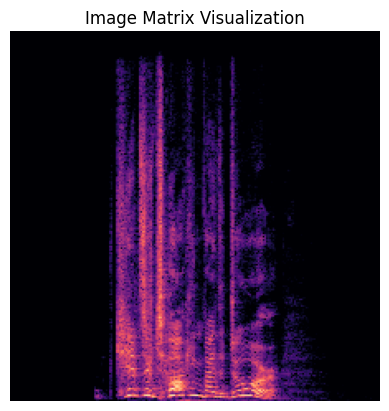

In [23]:
import matplotlib.pyplot as plt
plt.imshow(train_images[18])  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis labels and ticks
plt.title('Image Matrix Visualization')
plt.show()


In [24]:
from vit_keras import vit
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Load ViT-B16 model
pretrained_vit = vit.vit_b16(pretrained=True, pretrained_top=False ,include_top=False)  # Use weights='imagenet' if available

# Freeze the base ViT layers
for layer in pretrained_vit.layers:
    layer.trainable = False

# Add a custom classifier head
num_classes = 8
x = pretrained_vit.layers[-1].output  # Access the output of the last layer of the base ViT model
x = Dense(num_classes, activation='softmax')(x)  # Add a new Dense layer for classification
model = Model(inputs=pretrained_vit.input, outputs=x)

# Print summary of the model
model.summary()

347502902/347502902 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)         

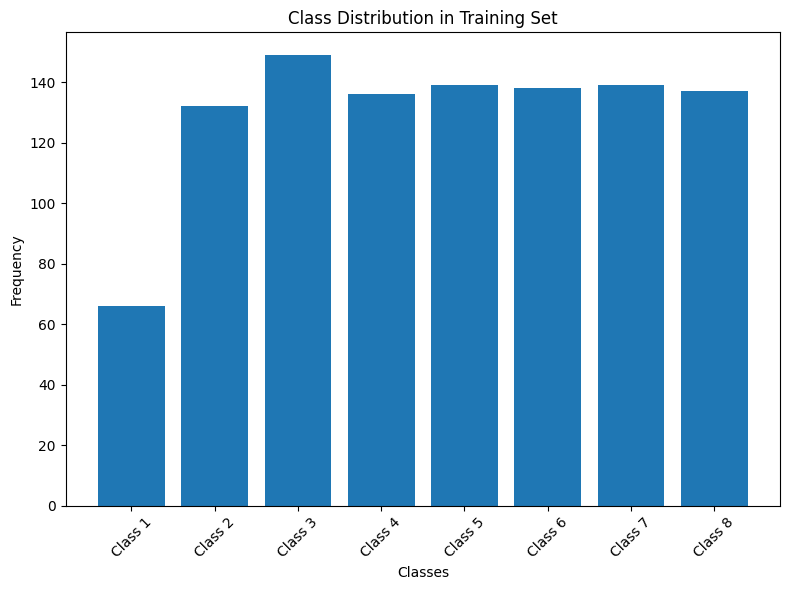

In [25]:
# Assuming train_labels is a one-hot encoded array of labels (num_samples, num_classes)
class_frequencies = np.sum(train_labels, axis=0)
num_classes = len(class_frequencies)
class_names = [f"Class {i+1}" for i in range(num_classes)]

plt.figure(figsize=(8, 6))
plt.bar(class_names, class_frequencies)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
'''# Step 2: Build the ViT Model
def create_model(input_shape, num_classes):
    model = vit.vit_b16(
        image_size=input_shape[:-1],
        activation='softmax',
        pretrained=True,
         pretrained_top=False,
        include_top=True,
        classes=num_classes
    )

    return model

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
# Define a function to create VGG16 model
def create_model(input_shape, num_classes):

    # Load pre-trained VGG16 model without the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model
    model = Sequential()
    model.add(base_model)  # Add VGG16 base model
    model.add(Flatten())  # Add Flatten layer to transition from convolutions to fully connected layers
    model.add(Dense(512, activation='relu'))  # Add a Dense layer
    model.add(Dense(num_classes, activation='softmax'))  # Add output layer with softmax activation

    return model


input_shape = (256, 256, 3)
num_classes = 8

# Create the ViT model
model = create_model(input_shape, num_classes)'''


"# Step 2: Build the ViT Model\ndef create_model(input_shape, num_classes):\n    model = vit.vit_b16(\n        image_size=input_shape[:-1],\n        activation='softmax',\n        pretrained=True,\n         pretrained_top=False,\n        include_top=True,\n        classes=num_classes\n    )\n\n    return model\n\nfrom tensorflow.keras.applications import VGG16\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Flatten, Dense\n# Define a function to create VGG16 model\ndef create_model(input_shape, num_classes):\n\n    # Load pre-trained VGG16 model without the top (fully connected) layers\n    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)\n\n    # Freeze the pre-trained convolutional layers\n    for layer in base_model.layers:\n        layer.trainable = False\n\n    # Create a new model\n    model = Sequential()\n    model.add(base_model)  # Add VGG16 base model\n    model.add(Flatten())  # Add Flatten layer to tran

In [ ]:
# Step 3: Train and Evaluate the Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

custom_lr = 0.0001  # Your desired learning rate
optimizer = Adam(learning_rate=custom_lr)
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Define early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=100, batch_size=16,callbacks=[early_stopping])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

# Step 4: Prediction and Inference

# Use the trained model to predict
predictions = model.predict(test_images)

Epoch 1/100
65/65 [==============================] - 45s 349ms/step - loss: 2.4606 - accuracy: 0.1129 - val_loss: 2.1919 - val_accuracy: 0.1379
Epoch 2/100
65/65 [==============================] - 19s 297ms/step - loss: 2.2415 - accuracy: 0.1264 - val_loss: 2.1033 - val_accuracy: 0.1724
Epoch 3/100
65/65 [==============================] - 19s 295ms/step - loss: 2.1525 - accuracy: 0.1593 - val_loss: 2.0375 - val_accuracy: 0.2241
Epoch 4/100
65/65 [==============================] - 19s 294ms/step - loss: 2.1175 - accuracy: 0.1737 - val_loss: 1.9886 - val_accuracy: 0.2414
Epoch 5/100
65/65 [==============================] - 19s 292ms/step - loss: 2.0761 - accuracy: 0.1931 - val_loss: 1.9267 - val_accuracy: 0.3103
Epoch 6/100
65/65 [==============================] - 19s 295ms/step - loss: 2.0256 - accuracy: 0.2220 - val_loss: 1.8829 - val_accuracy: 0.3017
Epoch 7/100
65/65 [==============================] - 18s 283ms/step - loss: 2.0061 - accuracy: 0.2181 - val_loss: 1.8512 - val_accuracy:

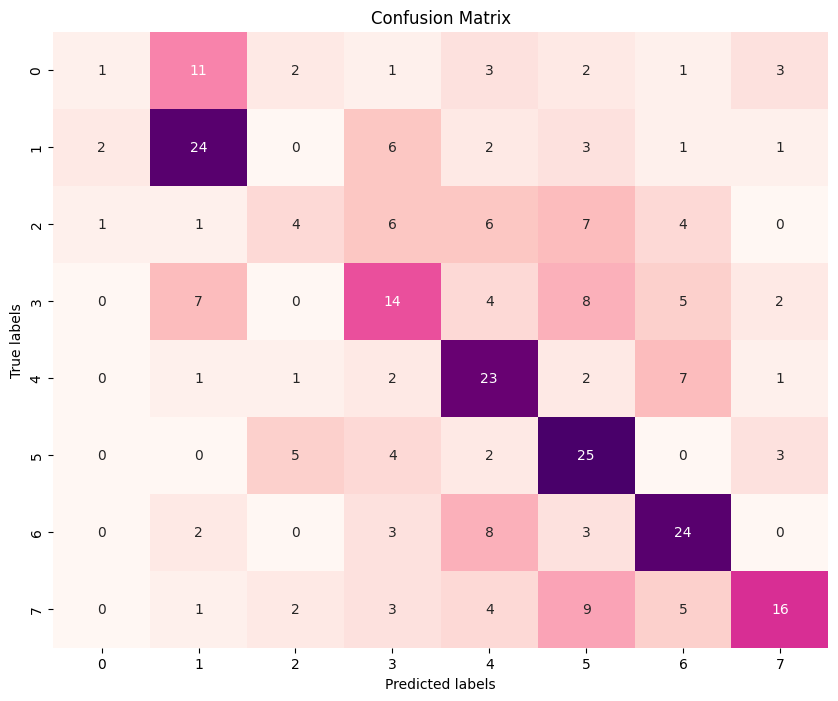

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get predicted labels (convert probabilities to classes)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels (convert one-hot encoded labels to classes)
true_classes = np.argmax(test_labels, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=range(8), yticklabels=range(8))  # Change xticklabels and yticklabels as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
